In [1]:
# imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from info_gain import info_gain
import pandas as pd
import pygeohash as gh
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
# global configurations
pd.set_option("display.max_colwidth", -1)

# configuration
config = {
    'FILE_PATH': '/Users/pradeep/Desktop/ProjectANotebooks/notebooks/cleaned_incidents1.csv'
    }
config

<ipython-input-1-3b7b22dad150>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


{'FILE_PATH': '/Users/pradeep/Desktop/ProjectANotebooks/notebooks/cleaned_incidents1.csv'}

In [2]:
# read csv
dataset = pd.read_csv(config['FILE_PATH'])
dataset

,ActionTaken,Address,AssetLabel,CauseCommunity,CauseEnvironment,CausePre,CauseTechnical,CauseWorkP,ContactType,CorrectProtection,...,MadeSafe,NetworkType,Status,SubmissionID,SubmittedDateTimeString,Voltage,WeatherStation,Postcode,Locality,Category
0,Crew isolated supply and undertook repairs,"PARA PARK, 1490 HENDY MAIN ROAD, PARAPARAP VIC 3240",NaN,NaN,NaN,NaN,Earth fault,NaN,NaN,NaN,...,1,Powercor,Report,1030,01:04.8,22kV AC,Avalon Airport,3240.0,Paraparap,OH Cable
1,Crew undertook repairs,"1154-1198 CHRISTIES ROAD, RAVENHALL VIC 3023",NaN,Working too close to underground cables,NaN,NaN,NaN,NaN,NaN,NaN,...,1,Powercor,Report,96,39:29.0,Earthing cable,Laverton Raaf,3023.0,Ravenhall,Dug up
2,Crew isolated supply and undertook repairs,"326 DUNBARS ROAD, PETERBOROUGH VIC 3270",NaN,NaN,NaN,NaN,Corrosion,NaN,NaN,1.0,...,1,Powercor,Report,86,45:20.1,22kV AC,Warrnambool Airport Ndb,3270.0,Peterborough,Connection
3,Crew undertook repairs,"41-49 BANK STREET, SOUTH MELBOURNE VIC 3205",NaN,Vandalism,NaN,NaN,NaN,NaN,NaN,1.0,...,1,CitiPower,Report,92,03:46.9,22kV AC,Essendon Airport,3205.0,South Melbourne,Other
4,Crew isolated supply and undertook repairs,"199 WILSONS ROAD, WHITTINGTON VIC 3219",NaN,Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,...,1,Powercor,Report,98,13:07.0,Low voltage AC (<1kV),Avalon Airport,3219.0,Whittington,Vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,The crew replaced a 3 phase FOLCB on the pole,"301 ST KILDA STREET, BRIGHTON VIC 3186",1806162,NaN,NaN,NaN,Earth fault,NaN,NaN,2.0,...,1,United Energy Distribution,Report,19935,19:54.4,Low voltage AC (<1kV),Moorabbin Airport,3186.0,Brighton,Connection
6500,Conductor repaired at point of contact.,"48 Banks Rd, Mount Wallace VIC 3342, Australia",30555208,Working too close to overhead lines,NaN,NaN,NaN,NaN,NaN,NaN,...,1,Powercor,Report,19968,21:53.4,12.7kV AC (SWER),Avalon Airport,3342.0,Mount Wallace,Vehicle
6501,On arrival crew isolated supply and arranged pole replacement.,"196 VALLANCE ROAD, OUYEN VIC 3490",32151770,NaN,NaN,NaN,Leakage,NaN,NaN,NaN,...,1,Powercor,Report,19972,39:17.4,22kV AC,Mildura Airport,3490.0,Ouyen,Pole
6502,On arrival crew isolated supply and carried out repairs,"Ford Rd, Ultima VIC 3544, Australia",32158284,"Crane, excavator or other construction/farming equipment",NaN,NaN,NaN,NaN,NaN,NaN,...,1,Powercor,Report,19973,02:13.1,22kV AC,Swan Hill Aerodrome,3544.0,Ultima,Vehicle


In [3]:
# check missing values
dataset.isna().sum()

ActionTaken                      0   
Address                          0   
AssetLabel                       1334
CauseCommunity                   4033
CauseEnvironment                 4996
CausePre                         6426
CauseTechnical                   3348
CauseWorkP                       6342
ContactType                      5650
CorrectProtection                2257
EventDescription                 0   
FailedAssets                     0   
FailedExplosion                  0   
FailedOilFilled                  0   
FailedOtherAssets                0   
FailedOtherAssetsOther           6494
FeederNumber                     1326
IncidentCause                    1   
IncidentConsequence              0   
IncidentDatetime                 0   
IncidentFireFFactorReportable    3840
IncidentFireSeverity             3737
IncidentID                       0   
IncidentLocationType             651 
IncidentLocationTypeOther        6442
IncidentNumber                   0   
IncidentType

In [4]:
# drop missing category rows
dataset['Category'].dropna(axis=0, inplace=True)

In [5]:
# categorical features
cat_features = ["CauseCommunity",
"CauseEnvironment",
"CausePre",
"CauseTechnical",
"CauseWorkP",
"ContactType",
"IncidentFireSeverity",
"IncidentLocationType",
"IncidentType",
"NetworkType",
"WeatherStation",
"Status",
"Voltage"]

In [6]:
# fill categorical features with most frequent values
dataset[cat_features] = dataset[cat_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
dataset[cat_features]

,CauseCommunity,CauseEnvironment,CausePre,CauseTechnical,CauseWorkP,ContactType,IncidentFireSeverity,IncidentLocationType,IncidentType,NetworkType,WeatherStation,Status,Voltage
0,Vehicle,Lightning,Unlikely,Earth fault,Not followed,Phase to earth,Small: 10 - 1000 sq.m,Roadway,Infrastructure (network-based),Powercor,Avalon Airport,Report,22kV AC
1,Working too close to underground cables,Lightning,Unlikely,Leakage,Not followed,Phase to earth,Negligible: no ground fire,Roadway,Infrastructure (network-based),Powercor,Laverton Raaf,Report,Earthing cable
2,Vehicle,Lightning,Unlikely,Corrosion,Not followed,Phase to earth,Negligible: no ground fire,Agricultural,Infrastructure (network-based),Powercor,Warrnambool Airport Ndb,Report,22kV AC
3,Vandalism,Lightning,Unlikely,Leakage,Not followed,Phase to earth,Negligible: no ground fire,Roadway,Infrastructure (network-based),CitiPower,Essendon Airport,Report,22kV AC
4,Vehicle,Lightning,Unlikely,Leakage,Not followed,Phase to earth,Negligible: no ground fire,Roadway,Infrastructure (network-based),Powercor,Avalon Airport,Report,Low voltage AC (<1kV)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6499,Vehicle,Lightning,Unlikely,Earth fault,Not followed,Phase to earth,Negligible: no ground fire,Residential,Infrastructure (network-based),United Energy Distribution,Moorabbin Airport,Report,Low voltage AC (<1kV)
6500,Working too close to overhead lines,Lightning,Unlikely,Leakage,Not followed,Phase to earth,Negligible: no ground fire,Agricultural,Infrastructure (network-based),Powercor,Avalon Airport,Report,12.7kV AC (SWER)
6501,Vehicle,Lightning,Unlikely,Leakage,Not followed,Phase to earth,Negligible: no ground fire,Agricultural,Infrastructure (network-based),Powercor,Mildura Airport,Report,22kV AC
6502,"Crane, excavator or other construction/farming equipment",Lightning,Unlikely,Leakage,Not followed,Phase to earth,Negligible: no ground fire,Agricultural,Infrastructure (network-based),Powercor,Swan Hill Aerodrome,Report,22kV AC


In [7]:
# integer features
int_features = ["CorrectProtection",
"FailedExplosion",
"FailedOilFilled",
'FailedOtherAssets',
"IncidentFireFFactorReportable",
"MadeSafe"]

# fill integer features with most frequent values
dataset[int_features] = dataset[int_features].apply(lambda x: x.fillna(x.value_counts().index[0]))
dataset[int_features]

,CorrectProtection,FailedExplosion,FailedOilFilled,FailedOtherAssets,IncidentFireFFactorReportable,MadeSafe
0,2.0,0,0,0,1.0,1
1,2.0,0,0,0,1.0,1
2,1.0,0,0,0,1.0,1
3,1.0,0,2,0,1.0,1
4,2.0,0,0,0,1.0,1
...,...,...,...,...,...,...
6499,2.0,0,0,0,1.0,1
6500,2.0,2,2,2,1.0,1
6501,2.0,2,2,2,1.0,1
6502,2.0,2,2,2,1.0,1


In [8]:
# irrelevant columns
id_columns = ['IncidentDatetime', 'IncidentID', 'IncidentNumber', 'SubmittedDateTimeString', 'SubmissionID']
# drop irrelevant columns
dataset.drop(columns=id_columns, inplace=True)

In [9]:
# drop more columns which have many missing values
drop_cols = ['IncidentLocationTypeOther', 'FeederNumber', 'AssetLabel', 'FailedOtherAssetsOther']
dataset.drop(columns=drop_cols, inplace=True)

# drop rows which have missing values
dataset.dropna(axis=0, inplace=True)

# target variable
target = dataset["Category"]

# drop target variable from features data
dataset.drop(columns=['Category'], inplace=True)

In [10]:
# deal with latitude and longitude
dataset['geohash']= dataset.apply(lambda x: gh.encode(x.Lat, x.Long, precision=5), axis=1)
dataset['geohash'].unique()
# drop Latitude and longitude features
dataset.drop(columns=['Lat','Long'], axis=1, inplace=True)

In [11]:
# calculate information gain
gain = []
for col in dataset.columns:
   #print(f'Info gain for col: {col} and Category')
    gain.append((col, (info_gain.info_gain(dataset[col], target))))

# sort information gain by higest to lowest
sorted_gain = sorted(gain, key = lambda x: x[1], reverse=True)
print(sorted_gain)

[('EventDescription', 2.408582574837527), ('Address', 2.398837058180214), ('IncidentCause', 2.304735507250127), ('ActionTaken', 1.871432682591843), ('FailedAssets', 1.290274454354443), ('Locality', 1.1888499612385521), ('geohash', 1.1723576967494589), ('IncidentConsequence', 0.8837252313207711), ('Postcode', 0.8104323310214845), ('CauseTechnical', 0.7110929675670261), ('CauseCommunity', 0.646709246867833), ('CauseEnvironment', 0.5017177140453194), ('Voltage', 0.3104016891631367), ('WeatherStation', 0.19899579950237545), ('NetworkType', 0.12088036561389792), ('IncidentLocationType', 0.11247695042401862), ('IncidentFireSeverity', 0.09330292243356364), ('CorrectProtection', 0.07711600530001572), ('IncidentType', 0.05199923148451538), ('FailedOilFilled', 0.03260851410272514), ('FailedExplosion', 0.024429459644641383), ('FailedOtherAssets', 0.02189663004370912), ('CauseWorkP', 0.02061169581677208), ('ContactType', 0.01659764845396057), ('MadeSafe', 0.013665125774209974), ('IncidentFireFFact

In [12]:
# show result in table format
from tabulate import tabulate
print(tabulate(sorted_gain))

-----------------------------  ----------
EventDescription               2.40858
Address                        2.39884
IncidentCause                  2.30474
ActionTaken                    1.87143
FailedAssets                   1.29027
Locality                       1.18885
geohash                        1.17236
IncidentConsequence            0.883725
Postcode                       0.810432
CauseTechnical                 0.711093
CauseCommunity                 0.646709
CauseEnvironment               0.501718
Voltage                        0.310402
WeatherStation                 0.198996
NetworkType                    0.12088
IncidentLocationType           0.112477
IncidentFireSeverity           0.0933029
CorrectProtection              0.077116
IncidentType                   0.0519992
FailedOilFilled                0.0326085
FailedExplosion                0.0244295
FailedOtherAssets              0.0218966
CauseWorkP                     0.0206117
ContactType                    0.0165976

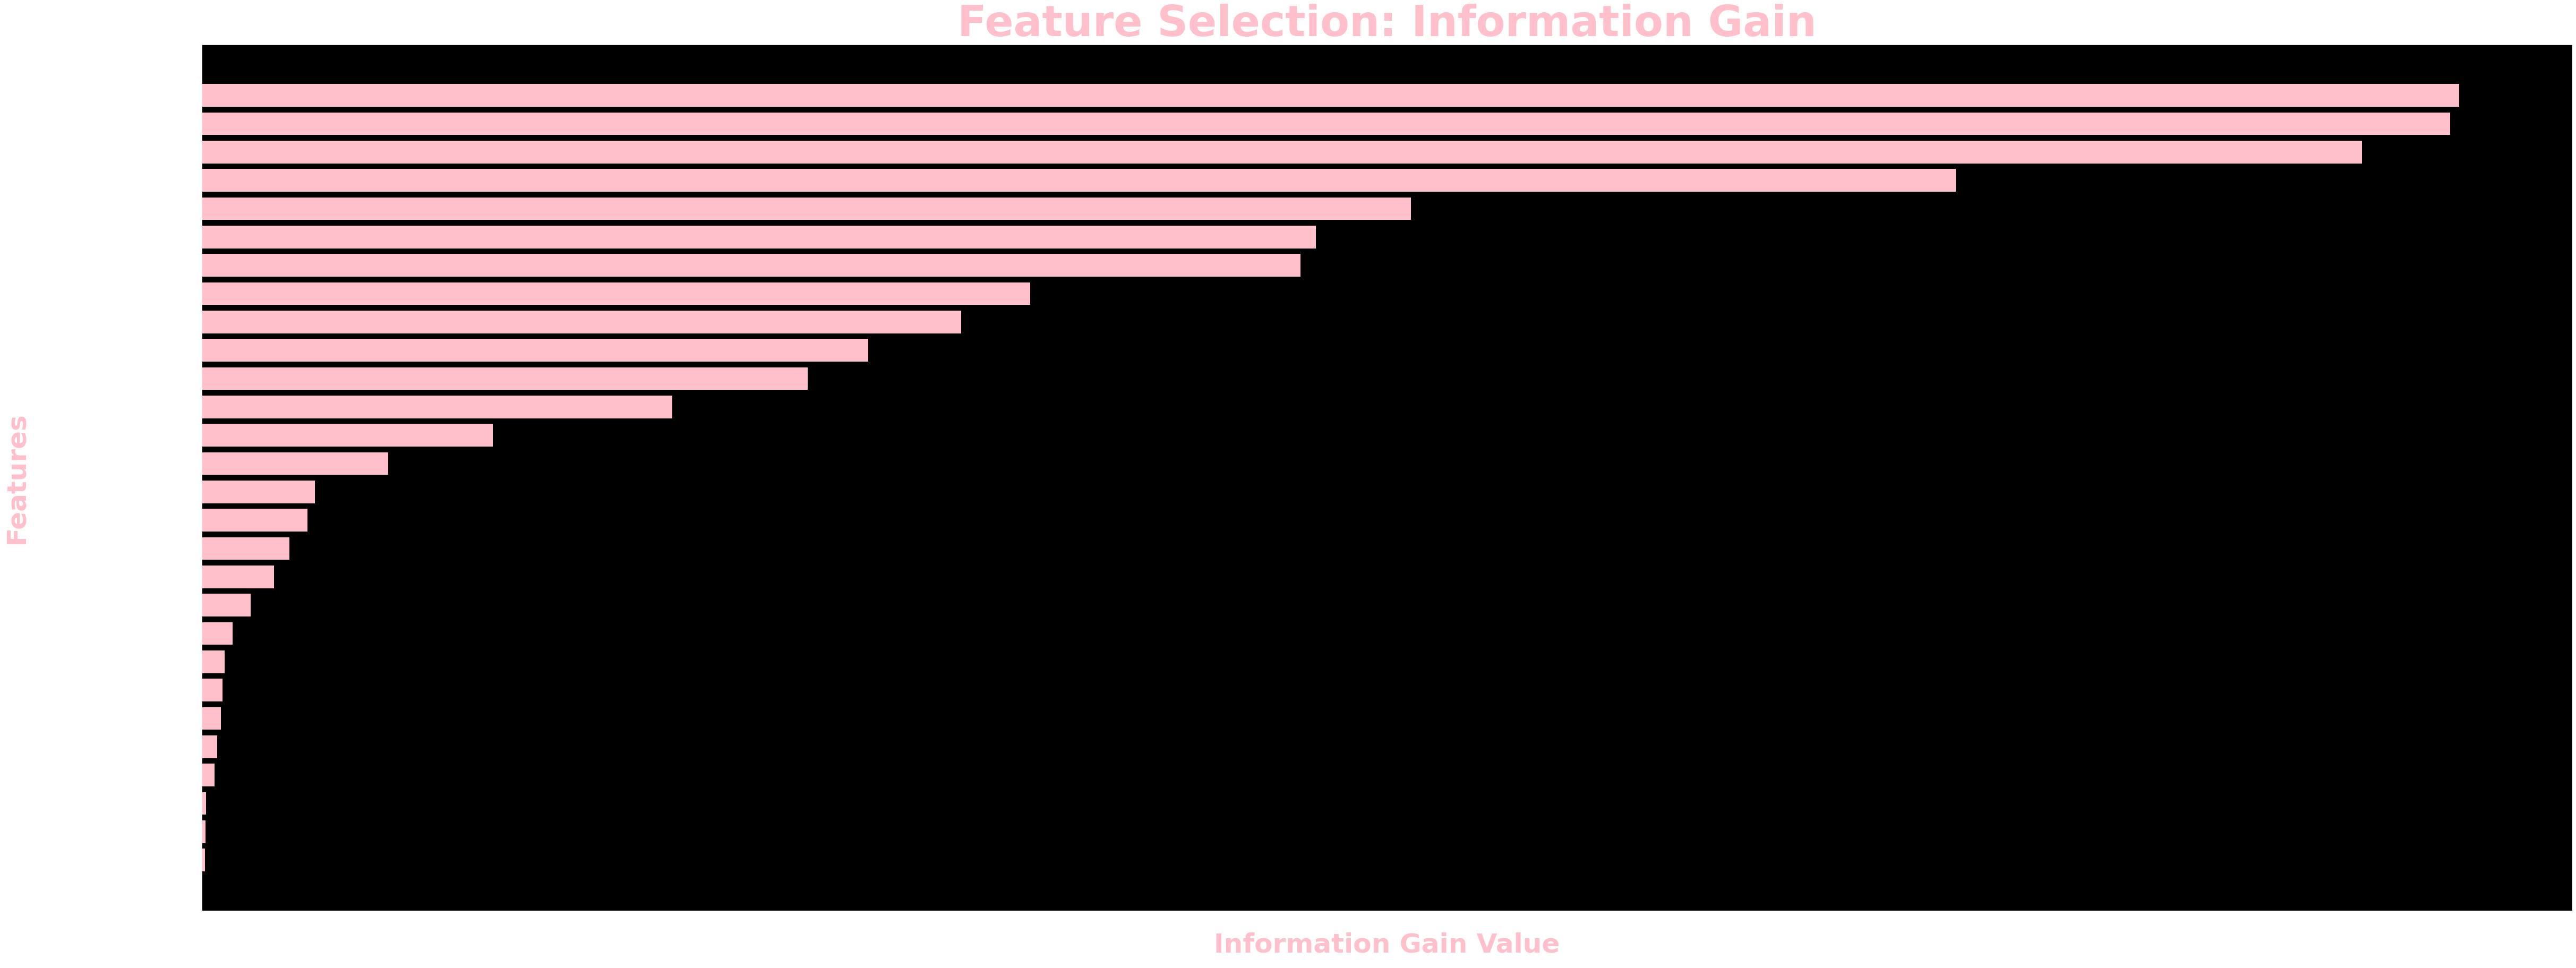

In [13]:
# plot the graph
import matplotlib.pyplot as plt
plt.figure(figsize=(80,30))
plt.style.use('dark_background')
x= [i[0] for i in sorted_gain[::-1]]
y = [i[1] for i in sorted_gain[::-1]]
plt.title('Feature Selection: Information Gain', fontsize=80, fontweight='bold', color='pink')
plt.barh( x, y, color='pink')
plt.xlabel('Information Gain Value', fontsize=50, fontweight='bold', color='pink')
plt.ylabel('Features', fontsize=50, fontweight='bold', color='pink')
plt.tick_params(axis='y', labelsize=28)
plt.tick_params(axis='x', labelsize=28)
plt.yticks(rotation=45)
plt.savefig('information_gain.png', transparent=True)
plt.show()